# 03. Convolutional Neural Networks and Computer Vision with TensorFlow

So far, we have covered the basics of TensorFlow and built a handful of models to work across different problems.

Now we're going to get specific and see how a special kind of network, convolutional neural networks (CNNs), can be used for computer vision (detecting patters in visual data).

> 🔑 **Note:** In depp learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some of these architectures generally work better than others.

For example, you might want to:

* Classify whether a picture of food contains pizza or steak (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)

In this notebook, we're going to follow the TensorFlow modeling workflow we've been following so far whilst learning about how to build and use CNNs.

### Get the Data

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes.

In [13]:
import zipfile

# Download zip file of pizza_steak images
!curl -O -s https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
    
# Unzip the download file
zip_ref = zipfile.ZipFile('pizza_steak.zip', 'r')
zip_ref.extractall()
zip_ref.close()

### Inspect the Data

In [14]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "pizza_steak".
There are 2 directories and 0 images in "pizza_steak\test".
There are 0 directories and 250 images in "pizza_steak\test\pizza".
There are 0 directories and 250 images in "pizza_steak\test\steak".
There are 2 directories and 0 images in "pizza_steak\train".
There are 0 directories and 750 images in "pizza_steak\train\pizza".
There are 0 directories and 750 images in "pizza_steak\train\steak".


In [15]:
# Get the class names (programmatically, this is very helpful with longer class lists)
import pathlib
import numpy as np

data_dir = pathlib.Path('pizza_steak/train/')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


> 🔑 **Note:** Whenever you are working with data, it's always a good idea to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. **Vizualize, vizualize, vizualize.**

In [16]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup target directory
    target_folder = target_dir + target_class
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    
    print(f'Image Shape: {img.shape}')
    
    return img

Image Shape: (288, 512, 3)


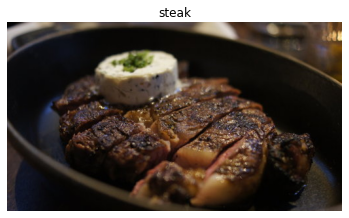

In [23]:
img = view_random_image(target_dir='pizza_steak/train/',
                        target_class='steak')

### Typical Architecture of a Convolutional Neural Network

| Hyperparameter/Layer Type | Function | Typical Values |
|:--------------------------|:---------|:---------------|
| Input Image(s)            | Target images you'd like to find patterns in | Whatever you can take a photo (or video) of |
| Input Layer | Takes in the target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution Layer | Extracts/learns the most important features from the target image(s) | Multiple, can create with `tf.keras.layers.ConvXD` (X can be multiple values) |
| Hidden Activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU (`tf.keras.activations.relu`) |
| Pooling Layer | Reduceds the dimensionality of learned image features | Average (`tf.keras.layers.AvgPool2D`) or Max (`tf.keras.layers.MaxPool2D`) |
| Fully Connected Layer | Further refines learned features from convolution layers | `tf.keras.layers.Dense` |
| Output Layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak, or sushi) |
| Output Activation | Adds non-linearity to output layer | `tf.keras.activations.sigmoid` (binary classification) or `tf.keras.activations.softmax` |

> 🔑 **Note:** A **baseline** is a score or evaluation metric you want to try and beat. Usually you'll start with a simple model, create a baseline and try to beat it by increasing complexity of the model. A really fun way to learn machine learning is to find some kind of modeling paper with a published result and try to beat it.

> 📖 **Resource:** The architecture we're using below is a scaled down version of [VGG-16](https://arxiv.org/abs/1505.06798), a convolutional neural network which came 2nd in the 2014 [ImageNet classification competition](https://image-net.org/).

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)

# Setup the train and test directories
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               seed=42)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# 1. Create a model

model_1 = Sequential([
    Conv2D(filters=10,
           kernel_size=3, # Can also be (3, 3)
           activation='relu',
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2, # Can also be (2, 2)
              padding='valid'), # Can also be 'same'
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(1, activation='sigmoid') # Binary activation output
])

# 2. Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 21s 447ms/step - loss: 0.6102 - accuracy: 0.6693 - val_loss: 0.4805 - val_accuracy: 0.7740
Epoch 2/5
47/47 [==============================] - 21s 447ms/step - loss: 0.4455 - accuracy: 0.8027 - val_loss: 0.3560 - val_accuracy: 0.8500
Epoch 3/5
47/47 [==============================] - 22s 468ms/step - loss: 0.4296 - accuracy: 0.8120 - val_loss: 0.4240 - val_accuracy: 0.8060
Epoch 4/5
47/47 [==============================] - 22s 477ms/step - loss: 0.3860 - accuracy: 0.8353 - val_loss: 0.3023 - val_accuracy: 0.8780
Epoch 5/5
47/47 [==============================] - 22s 472ms/step - loss: 0.3295 - accuracy: 0.8540 - val_loss: 0.3017 - val_accuracy: 0.8720


In [29]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

### Using a Previous Model

In [30]:
# Set random seed
tf.random.set_seed(42)

# 1. Create a model
model_2 = Sequential([
    Flatten(input_shape=(224, 224, 3)), # Dense layers expect a 1-dimensional vector as input
    Dense(4, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 2. Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 4s 73ms/step - loss: 0.8824 - accuracy: 0.5073 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 3s 70ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 3s 69ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 3s 69ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 3s 70ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [31]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


> 🔑 Note: You can think of trainable parameters as patterns a model can learn from data. Intuitiely, you might think more is better. And in some cases it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, a convolutional neural network seeks to sort out and learn the most important patterns in an image. So even though there are less learnable parameters in our convolutional neural network, these are often more helpful in decphering between different features in an image.

> 🔑 Note: Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the complexity of your model.

In [32]:
# Set random seed
tf.random.set_seed(42)

# 1. Create a model
model_3 = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(100, activation='relu'), # More neurons
    Dense(100, activation='relu'),
    Dense(100, activation='relu'), # Add a layer
    Dense(1, activation='sigmoid')
])

# 2. Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 5s 108ms/step - loss: 3.4369 - accuracy: 0.6240 - val_loss: 0.6542 - val_accuracy: 0.7240
Epoch 2/5
47/47 [==============================] - 5s 106ms/step - loss: 0.7446 - accuracy: 0.7113 - val_loss: 1.5126 - val_accuracy: 0.5080
Epoch 3/5
47/47 [==============================] - 5s 106ms/step - loss: 0.9286 - accuracy: 0.7020 - val_loss: 0.4427 - val_accuracy: 0.8020
Epoch 4/5
47/47 [==============================] - 5s 107ms/step - loss: 0.4988 - accuracy: 0.7767 - val_loss: 0.4222 - val_accuracy: 0.7940
Epoch 5/5
47/47 [==============================] - 5s 107ms/step - loss: 0.4861 - accuracy: 0.7933 - val_loss: 0.4311 - val_accuracy: 0.8000


In [33]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Even though this model has close to 500x (~15,000,000 vs ~31,000) more trainable parameters, `model_3` still doesn't outperform `model_1`.

### Binary Classification: Let's Break It Down

Whatever kind of data you're dealing with, it's a good idea to visualize at least 10-100 samples to start to building your own mental model of the data.

In our case, we might notice that the steak images tend to have darker colours where as pizza images tend to have a distinct circular shape in the middle. These might be patterns that our neural network picks up on.

You an also notice if some of your data is messed up (for example, has the wrong label) and start to consider ways you might go about fixing it.

> 📖 **Resource:** To see how this data was processed into the file format we're using, see the [preprocessing handbook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

In [34]:
# Uncomment to re-import data if necessary
# import zipfile

# # Download zip file of pizza_steak images
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

Image Shape: (512, 512, 3)
Image Shape: (434, 512, 3)


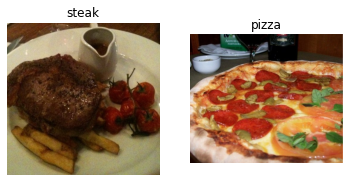

In [38]:
# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image('pizza_steak/train/', 'steak')
plt.subplot(1, 2, 2)
pizza_image = view_random_image('pizza_steak/train/', 'pizza')

### Preprocessing (Prepare for Model)

In [39]:
# Define train and test directory paths
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'



Our next step is to turn our data into batches.

A batch is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:

* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32?

A [batch size of 32 is good for your health](https://twitter.com/ylecun/status/989610208497360896?s=20).

No seriously, there are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

To turn our data into batches, we'll first create an instance of `ImageDataGenerator` for each of our datasets.


In [40]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

> 🔑 **Note:** For more transformation options such as data augmentation (we'll see this later), refer to the [`ImageDataGenerator` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [41]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.




Wonderful! Looks like our training dataset has 1500 images belonging to 2 classes (pizza and steak) and our test dataset has 500 images also belonging to 2 classes.

Some things to here:

* Due to how our directories are structured, the classes get inferred by the subdirectory names in train_dir and test_dir.
* The target_size parameter defines the input size of our images in (height, width) format.
* The class_mode value of 'binary' defines our classification problem type. If we had more than two classes, we would use 'categorical'.
* The batch_size defines how many images will be in each batch, we've used 32 which is the same as the default.

In [43]:
# Get a sample of the training data batch
images, labels = train_data.next() # Get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [45]:
# Look at image and label data
images[0], images[0].shape, labels

(array([[[0.3921569 , 0.16078432, 0.13725491],
         [0.37647063, 0.14509805, 0.12156864],
         [0.37647063, 0.15294118, 0.11764707],
         ...,
         [0.13725491, 0.09411766, 0.08627451],
         [0.12156864, 0.08235294, 0.07843138],
         [0.11764707, 0.07843138, 0.08235294]],
 
        [[0.37647063, 0.16078432, 0.13333334],
         [0.3921569 , 0.1764706 , 0.14901961],
         [0.4039216 , 0.19215688, 0.15294118],
         ...,
         [0.14509805, 0.08627451, 0.07450981],
         [0.14117648, 0.08627451, 0.08235294],
         [0.14117648, 0.08627451, 0.08627451]],
 
        [[0.33333334, 0.13725491, 0.10196079],
         [0.36078432, 0.16470589, 0.12941177],
         [0.34509805, 0.14901961, 0.1137255 ],
         ...,
         [0.14901961, 0.07843138, 0.0627451 ],
         [0.13725491, 0.06666667, 0.05882353],
         [0.15294118, 0.07450981, 0.07058824]],
 
        ...,
 
        [[0.8862746 , 0.7843138 , 0.6784314 ],
         [0.854902  , 0.7607844 , 0.65098

Due to our rescale parameter, the images are now in (224, 224, 3) shape tensors with values between 0 and 1.

Due to the class_mode parameter being 'binary' our labels are either 0 (pizza) or 1 (steak).

Now that our data is ready, our model is going to try and figure out the patterns between the image tensors and the labels.

In [46]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [48]:
# 1. Create the model
model_4 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])



Great! We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

    Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output

Let's discuss some of the components of the Conv2D layer:

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A **feature** can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these **features** are not defined by us, instead, the model learns them as it applies different filters across the image.

> 📖 **Resources:** For a great demonstration of these in action, be sure to spend some time going through the following:
> * [CNN Explainer Webpage](https://poloclub.github.io/cnn-explainer/) - a great visual overview of many of the concepts we're replicating here with code.
> * [A guide to convolutional arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) - a phenomenal introduction to the math going on behind the scenes of a convolutional neural network.
> * For a great explanation of padding, see this [Stack Overflow answer](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t/39371113#39371113).

Now our model is ready, let's compile it.


In [49]:
# 2. Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

Since we're working on a binary classification problem (pizza vs. steak), the `loss` function we're using is `'binary_crossentropy'`, if it was multi-class, we might use something like `'categorical_crossentropy'`.

Adam with all the default settings is our optimizer and our evaluation metric is accuracy.
4. Fit a model

Our model is compiled, time to fit it.

You'll notice two new parameters here:

* `steps_per_epoch` - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of `train_data` (1500 images in batches of 32 = 1500/32 = ~47 steps)
* `validation_steps` - same as above, except for the `validation_data` parameter (500 test images in batches of 32 = 500/32 = ~16 steps)



In [50]:
len(train_data), len(test_data)

(47, 16)

In [51]:
# 3. Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 28s 582ms/step - loss: 1.8233 - accuracy: 0.6240 - val_loss: 0.4472 - val_accuracy: 0.7940
Epoch 2/5
47/47 [==============================] - 29s 615ms/step - loss: 0.4444 - accuracy: 0.8147 - val_loss: 0.3677 - val_accuracy: 0.8440
Epoch 3/5
47/47 [==============================] - 28s 585ms/step - loss: 0.3464 - accuracy: 0.8627 - val_loss: 0.3729 - val_accuracy: 0.8440
Epoch 4/5
47/47 [==============================] - 27s 570ms/step - loss: 0.2404 - accuracy: 0.9167 - val_loss: 0.4388 - val_accuracy: 0.7980
Epoch 5/5
47/47 [==============================] - 26s 562ms/step - loss: 0.1070 - accuracy: 0.9673 - val_loss: 0.5644 - val_accuracy: 0.7520


<AxesSubplot:>

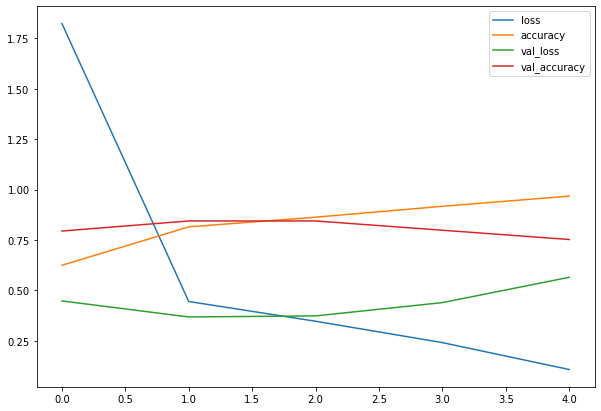

In [52]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7))



Hmm, judging by our loss curves, it looks like our model is overfitting the training dataset.

> 🔑 Note: When a model's validation loss starts to increase, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset too well and thus its ability to generalize to unseen data will be diminished.

To further inspect our model's training performance, let's separate the accuracy and loss curves.


In [57]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel = 'Epochs'
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel = 'Epochs'
    plt.legend()

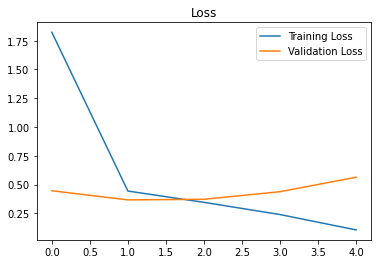

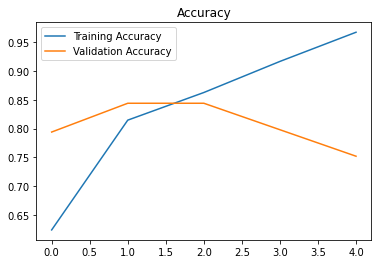

In [58]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

The ideal position for these two curves is to follow each other. If anything, the validation curve should be slightly under the training curve. If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.

In [59]:
# Check out the model architecture 
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### Adjust the Model Parameters

Fitting a machine learning model comes in 3 steps:

1. Create a basline.
2. Beat the baseline by overfitting a larger model.
3. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:

* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

Not really...

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:

* A ConvNet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A ConvNet with max pooling and data augmentation

For the first model, we'll follow the modified basic CNN structure:

    Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output

Let's build it. It'll have the same structure as `model_4` but with a `MaxPool2D()` layer after each convolutional layer.

In [60]:
# 1. Create the model
model_5 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2), # Reduce number of features by half
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

Woah, we've got another layer type we haven't seen before.

If convolutional layers learn the features of an image you can think of a Max Pooling layer as figuring out the most important of those features. We'll see this an example of this in a moment.

In [61]:
# 2. Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 3. Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 10s 209ms/step - loss: 0.6532 - accuracy: 0.6087 - val_loss: 0.5319 - val_accuracy: 0.7380
Epoch 2/5
47/47 [==============================] - 10s 207ms/step - loss: 0.4736 - accuracy: 0.7760 - val_loss: 0.4827 - val_accuracy: 0.7520
Epoch 3/5
47/47 [==============================] - 10s 209ms/step - loss: 0.4401 - accuracy: 0.8013 - val_loss: 0.3538 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 10s 214ms/step - loss: 0.3960 - accuracy: 0.8313 - val_loss: 0.3302 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 10s 219ms/step - loss: 0.3786 - accuracy: 0.8453 - val_loss: 0.3250 - val_accuracy: 0.8600




Okay, it looks like our model with max pooling (`model_5`) is performing worse on the training set but better on the validation set.

Before we checkout its training curves, let's check out its architecture.


In [62]:
# Check out the model architecture
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

Do you notice what's going on here with the output shape in each `MaxPooling2D` layer?

It gets halved each time. This is effectively the `MaxPooling2D` layer taking the outputs of each `Conv2D` layer and saying "I only want the most important features, get rid of the rest".

The bigger the `pool_size` parameter, the more the max pooling layer will squeeze the features out of the image. However, too big and the model might not be able to learn anything.

The results of this pooling are seen in a major reduction of total trainable parameters (8,861 in `model_5` and 477,431 in `model_4`).

Time to check out the loss curves.

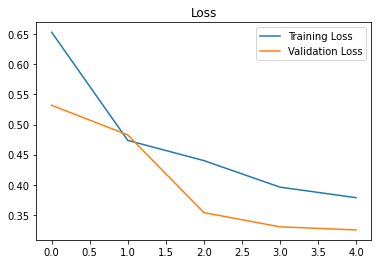

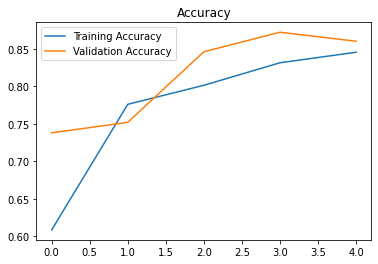

In [63]:
# Plot the loss curves of model_5
plot_loss_curves(history_5)

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

Time to dig into our bag of tricks and try another method of overfitting prevention, data augmentation.

First, we'll see how it's done with code then we'll discuss what it's doing.

To implement data augmentation, we'll have to reinstantiate our [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instances.

In [ ]:
about halfway down